# Imports and data loading

**Experiment**: <br>
1. Inputs : modal_price from time t-0 to t-30
2. Output : modal_price from t+1 to t+5
3. Models : 
  1. LSTM.
  2. Bi-Dir LSTM.
  3. Stacked LSTM.
  4. Stacked Bi-Dir LSTM.
  5. Stacked LSTM and Bi-Dir LSTM combination. 
  6. Stacked Bi-Dir LSTM (Model 4 with more Epochs).

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
import seaborn as sns

from pylab import rcParams
rcParams['figure.figsize'] = 15,8

from warnings import filterwarnings
filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose

import sklearn.metrics as metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Flatten, TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
from statsmodels.tsa.stattools import adfuller

In [4]:
from google. colab import drive
drive.mount ('/content/drive/')

Mounted at /content/drive/


In [5]:
df_tomato = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Tomato_Kolar_2020_23.xlsx',
                          index_col = 5,parse_dates=True)
df_tomato.shape

(1163, 9)

In [6]:
df_tomato.head(5)

,state,district,market,commodity,variety,min_price,max_price,modal_price,quantity
arrival_date,,,,,,,,,
2023-01-01,Karnataka,Kolar,Kolar,Tomato,Tomato,400,1330,730,6224
2023-01-02,Karnataka,Kolar,Kolar,Tomato,Tomato,400,1670,930,4439
2023-01-03,Karnataka,Kolar,Kolar,Tomato,Tomato,400,1670,930,5983
2023-01-04,Karnataka,Kolar,Kolar,Tomato,Tomato,330,1330,800,7830
2023-01-05,Karnataka,Kolar,Kolar,Tomato,Tomato,330,1200,530,6310


# EDA - Univariate Multi-step ahead time series forcasting

In [8]:
#df_tomato_2 = df_tomato.set_index('arrival_date',drop=True, verify_integrity=True)

In [9]:
#df_tomato_2.sort_index(axis=1)

In [7]:
df_tomato_2 = df_tomato.drop(['state','district', 'market', 'commodity', 'variety'], axis=1)
df_tomato_2.head()

,min_price,max_price,modal_price,quantity
arrival_date,,,,
2023-01-01,400,1330,730,6224
2023-01-02,400,1670,930,4439
2023-01-03,400,1670,930,5983
2023-01-04,330,1330,800,7830
2023-01-05,330,1200,530,6310


In [10]:
df_tomato_2.isnull().sum()

min_price      0
max_price      0
modal_price    0
quantity       0
dtype: int64

In [11]:
cor_matrix = df_tomato_2.corr()

Text(0.5, 1.0, 'Heat map of correlation between features')

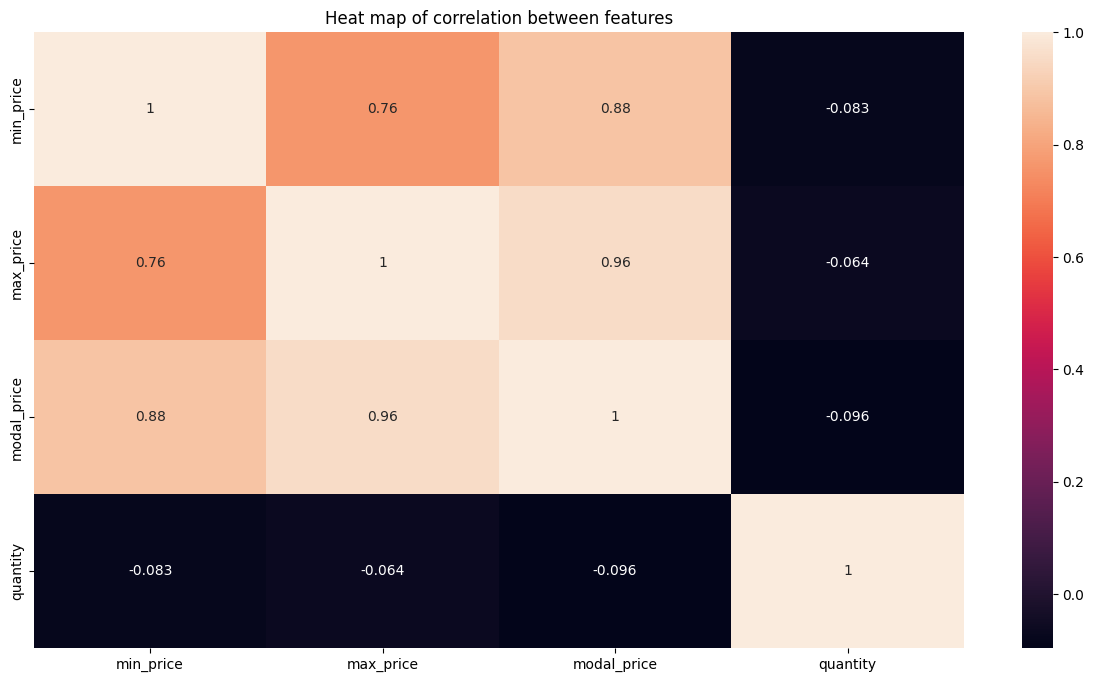

In [12]:
sns.heatmap(cor_matrix,annot=True)
plt.title("Heat map of correlation between features")

In [13]:
df_tomato_2.head()

,min_price,max_price,modal_price,quantity
arrival_date,,,,
2023-01-01,400,1330,730,6224
2023-01-02,400,1670,930,4439
2023-01-03,400,1670,930,5983
2023-01-04,330,1330,800,7830
2023-01-05,330,1200,530,6310


In [14]:
# Drop min_price and max_price because of hig auto-correlation
# Drop quantity to keep it univariate
df_tomato_3 = df_tomato_2.drop(['min_price','max_price','quantity'], axis=1)
df_tomato_3.head()

,modal_price
arrival_date,
2023-01-01,730
2023-01-02,930
2023-01-03,930
2023-01-04,800
2023-01-05,530


In [15]:
# Creating a new dataset and Sorting in ascending order of time series
#df_tomato_3 = df_tomato_2[['quantity','min_price','max_price','modal_price']]
#df_tomato_3.sort_index(ascending=True,inplace=True)
df_tomato_3.sort_index(inplace=True)
df_tomato_3.head()

,modal_price
arrival_date,
2020-01-01,733
2020-01-02,986
2020-01-03,1047
2020-01-04,1033
2020-01-05,1033


## Checking trend and Seasonality

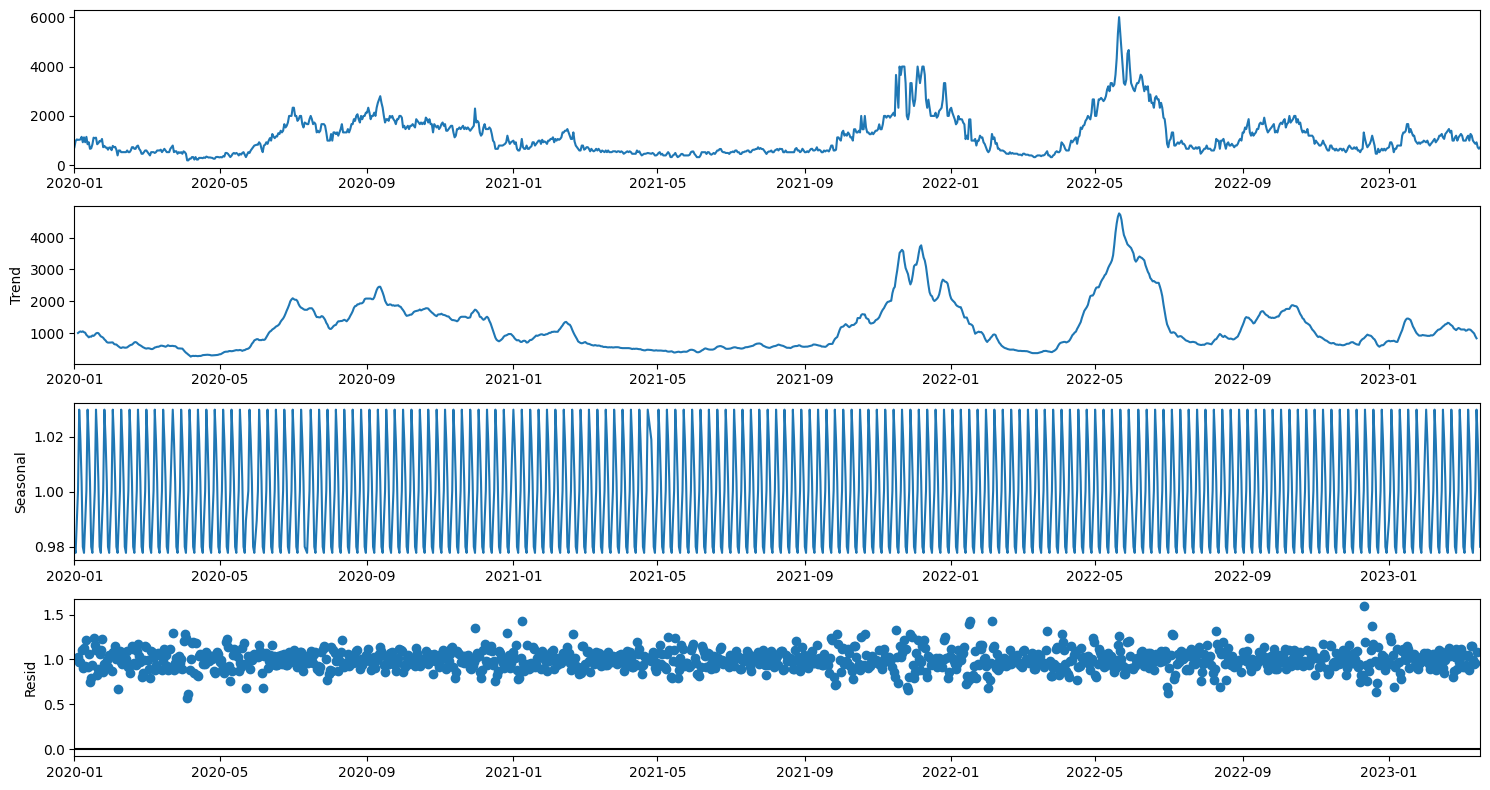

In [16]:
# Checking for additive trend - Week
mul_decompose_result_1 = seasonal_decompose(df_tomato_3, model="multiplicative",period=7)

trend = mul_decompose_result_1.trend
seasonal = mul_decompose_result_1.seasonal
residual = mul_decompose_result_1.resid

mul_decompose_result_1.plot();

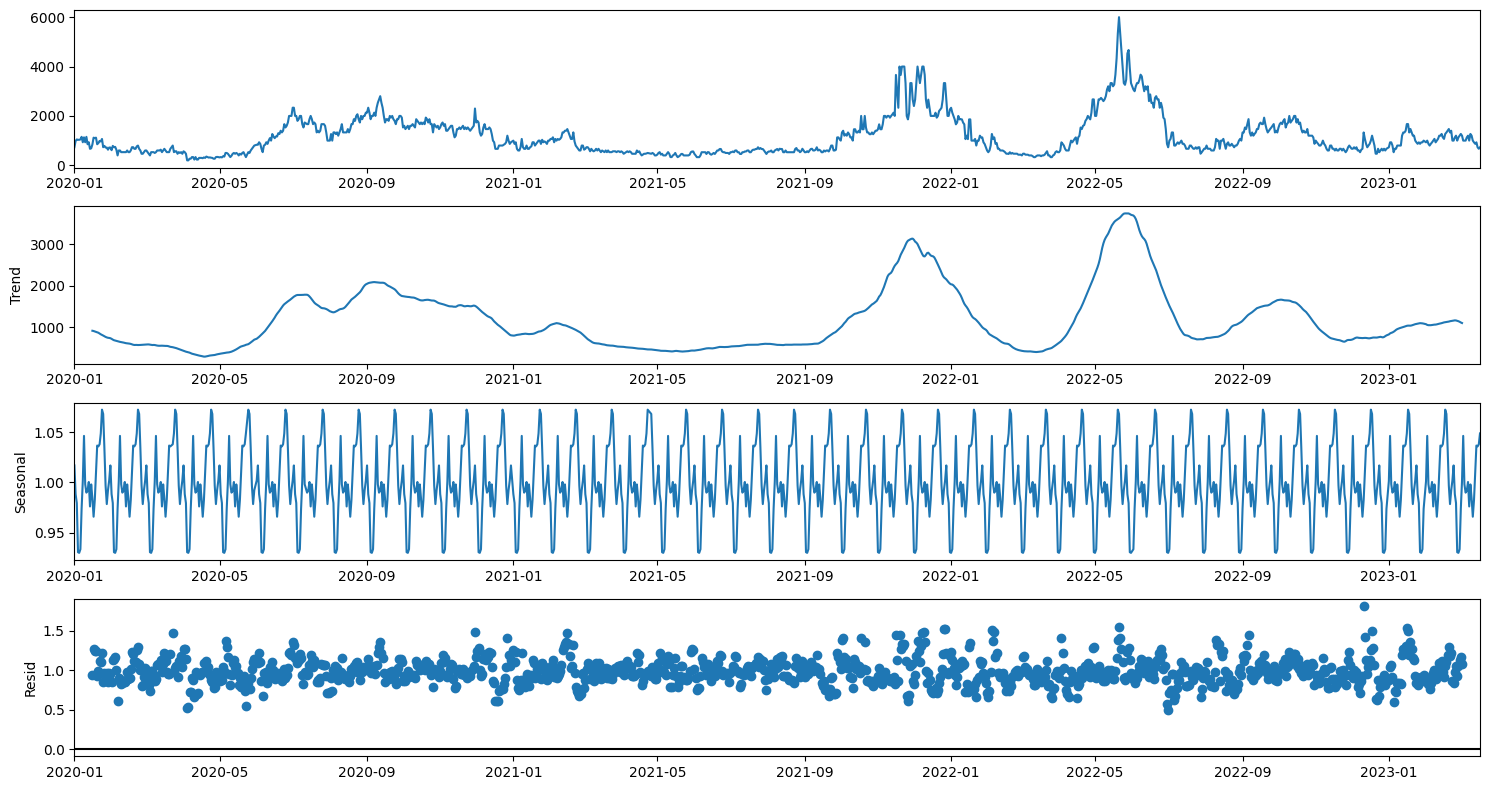

In [17]:
# Checking for additive trend - Month
mul_decompose_result_2 = seasonal_decompose(df_tomato_3, model="multiplicative",period=30)

trend = mul_decompose_result_2.trend
seasonal = mul_decompose_result_2.seasonal
residual = mul_decompose_result_2.resid

mul_decompose_result_2.plot();

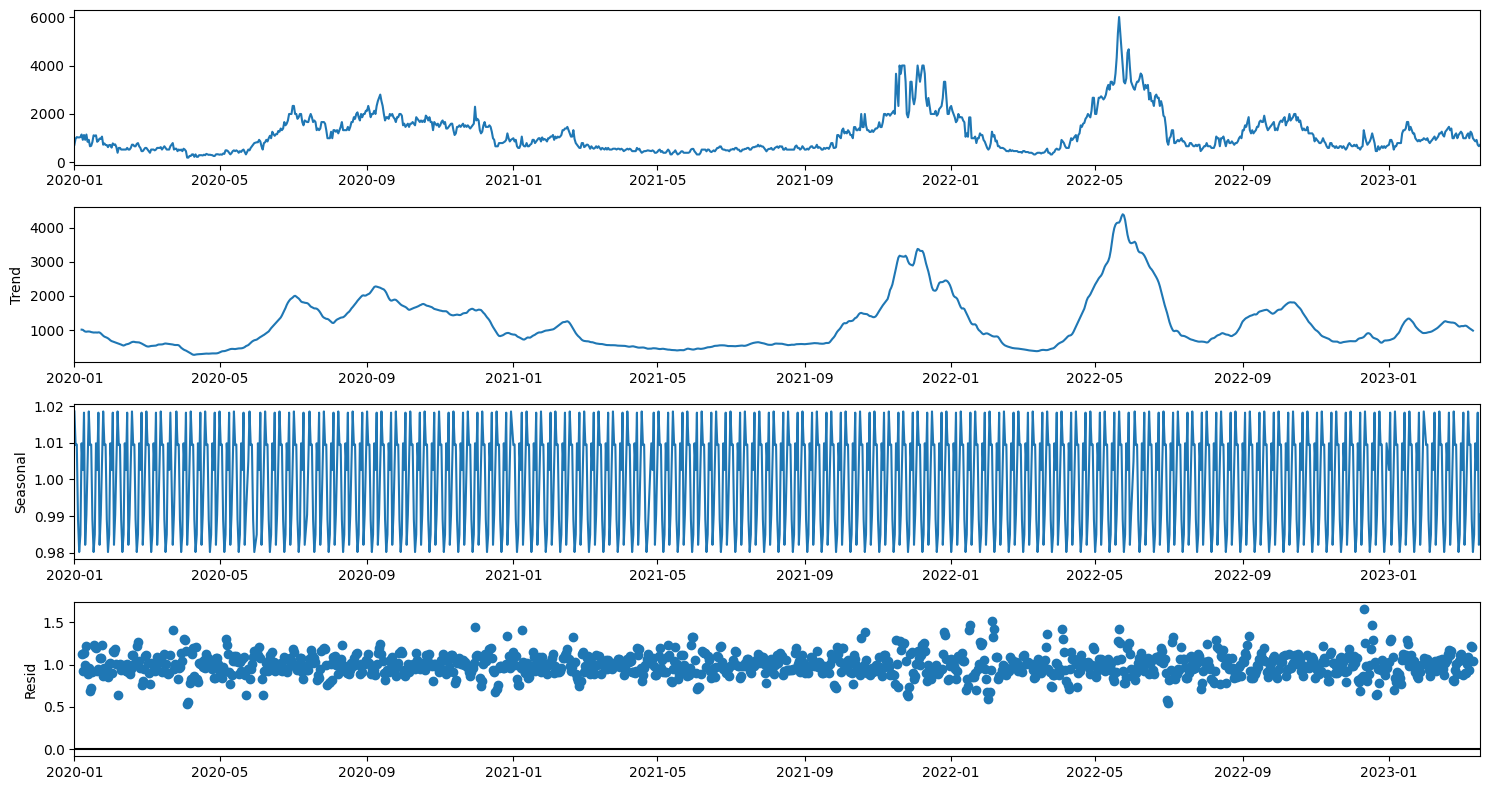

In [18]:
# Checking for multiplicative trend - Year
mul_decompose_result_3 = seasonal_decompose(df_tomato_3, model="multiplicative",period=12)

trend = mul_decompose_result_3.trend
seasonal = mul_decompose_result_3.seasonal
residual = mul_decompose_result_3.resid

mul_decompose_result_3.plot();

Inference: There is no trend observed, but there is definitely seasonality in the dataset

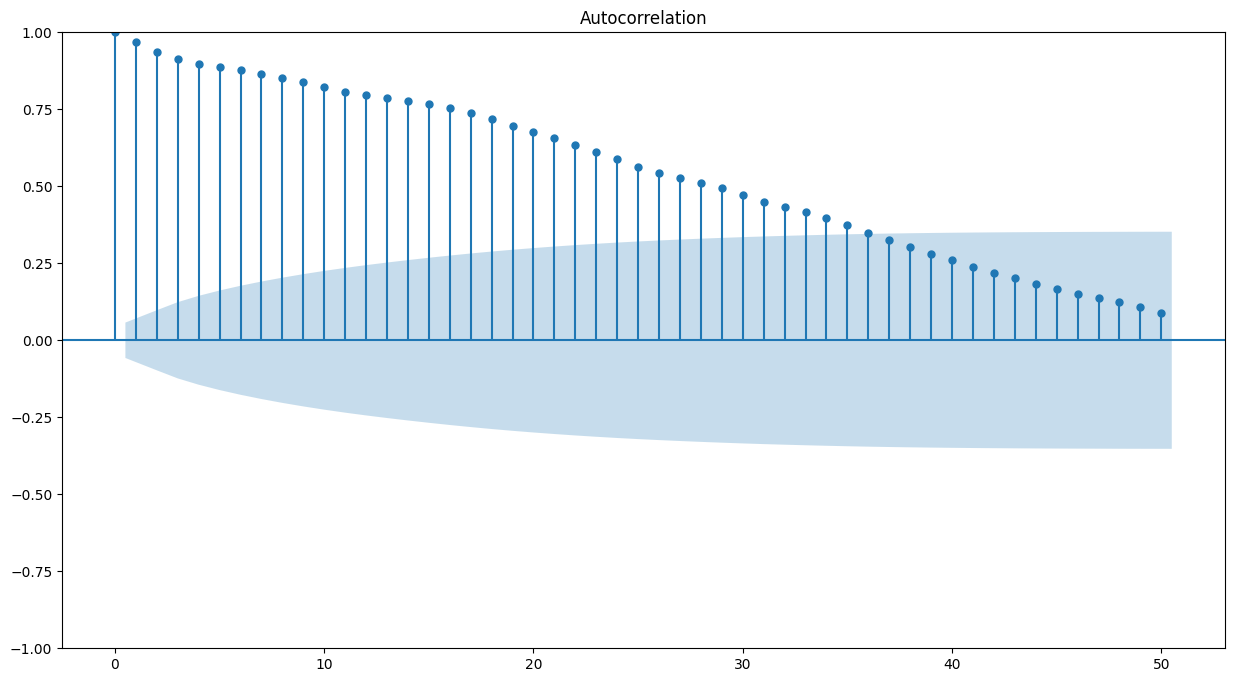

In [19]:
# ACF test
plot_acf(df_tomato_3,lags=50);

**Inference**: <br>High degree or auto-correlation is observed at Lag 1 to 36 observations in ACF plot, therefore for every 36 days the seasonality cycle repeates. MA = 36<br>
There are several autocorrelations that are statistically non-zero. Therefore, the time series is non-random.

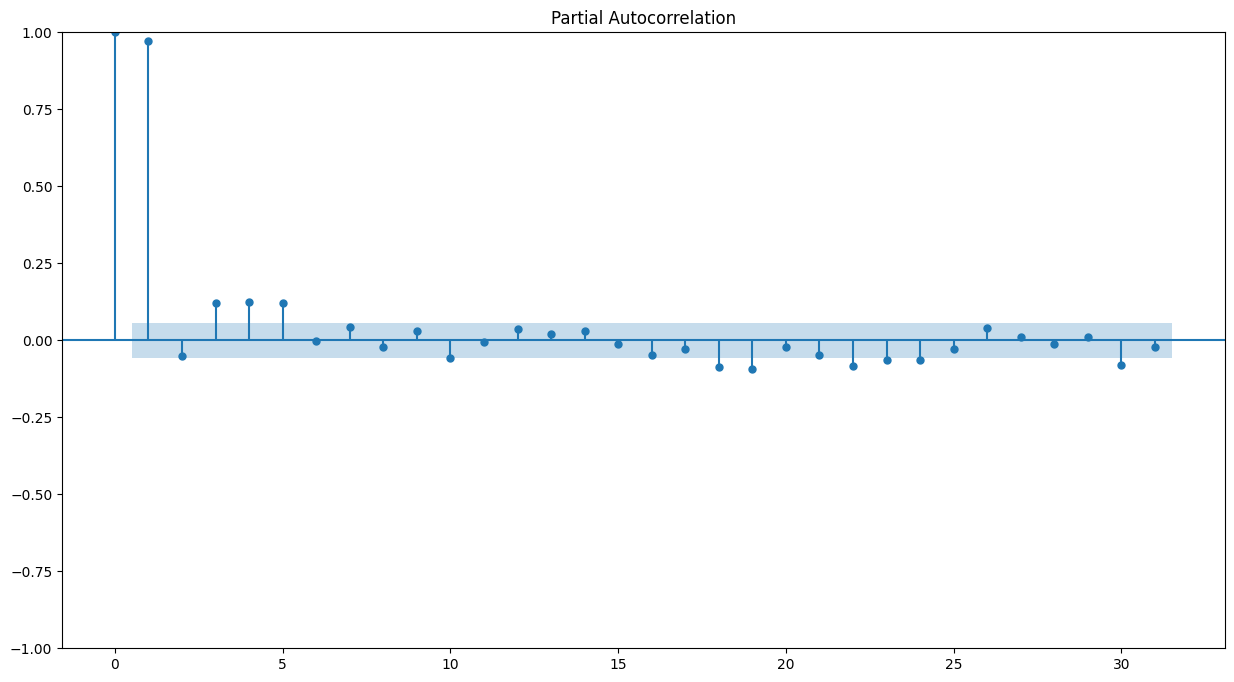

In [20]:
# P-ACF test
plot_pacf(df_tomato_3);

**Inference**: <br>High degree or auto-correlation is observed at Lag = 1 observations in PACF plot, AR = 1<br>
There are several autocorrelations that are statistically non-zero. Therefore, the time series is non-random.

## Dicky-Fuller Test for Stationarity

In [21]:
dftest = adfuller(df_tomato_3['modal_price'], autolag = 'AIC')

In [22]:
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -4.273120122965854
2. P-Value :  0.0004943093249104255
3. Num Of Lags :  23
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1139
5. Critical Values :
	 1% :  -3.4361042569951805
	 5% :  -2.8640808675675826
	 10% :  -2.568122823703617


We can interpret above results based on p-values of result.<br>

p-value > 0.05 - This implies that time-series is non-stationary.<br>
p-value <=0.05 - This implies that time-series is stationary.<br><br>
We can see from the above results that p-value 0.00049 is **less** than 0.05 hence our time-series is stationary. It does not have time-dependent components.

# Preparing the dataset for training

### Creating Feature variable

In [23]:
df_tomato_4 = df_tomato_3[['modal_price']]
df_tomato_4.rename(columns={'modal_price':'feature'}, inplace=True)
df_tomato_4.head()

,feature
arrival_date,
2020-01-01,733
2020-01-02,986
2020-01-03,1047
2020-01-04,1033
2020-01-05,1033


In [24]:
# Function to create as many as features to represent the window size
def createWindow(winSize):
  df_temp = pd.DataFrame()
  for i in range(0,winSize):
    df_temp["feature_t"+str(i+1)] = df_tomato_4['feature'].shift(i)
  return df_temp

In [26]:
# Generating new features
df_newCols = createWindow(30)
df_newCols.head()

,feature_t1,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,feature_t8,feature_t9,feature_t10,...,feature_t21,feature_t22,feature_t23,feature_t24,feature_t25,feature_t26,feature_t27,feature_t28,feature_t29,feature_t30
arrival_date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,986,733.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,1047,986.0,733.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,1033,1047.0,986.0,733.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,1033,1033.0,1047.0,986.0,733.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
#Replacing the orginal column with newly generated dataframe
df_tomato_4 = df_newCols.copy()

In [29]:
# Replacing null values with 0, thus created window of 30 days as each input.
for val in df_tomato_4.columns:
  df_tomato_4[val].fillna(0, inplace=True)
df_tomato_4.head()

,feature_t1,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,feature_t8,feature_t9,feature_t10,...,feature_t21,feature_t22,feature_t23,feature_t24,feature_t25,feature_t26,feature_t27,feature_t28,feature_t29,feature_t30
arrival_date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,986,733.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,1047,986.0,733.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,1033,1047.0,986.0,733.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,1033,1033.0,1047.0,986.0,733.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# joining with base dataframe
#df_tomato_4 = df_tomato_3.join(df_newCols)
#df_tomato_4.head()

### Creating Target Variable

In [30]:
# Creating target Variables
def createTargets(winSize):
  df_temp = pd.DataFrame()
  for i in range(1,winSize+1):
    df_temp["target_t"+str(i)] = df_tomato_3['modal_price'].shift(-i)
  return df_temp

In [31]:
# Generating target columns
df_newTargetCols = createTargets(5)
df_newTargetCols.head()

,target_t1,target_t2,target_t3,target_t4,target_t5
arrival_date,,,,,
2020-01-01,986.0,1047.0,1033.0,1033.0,1046.0
2020-01-02,1047.0,1033.0,1033.0,1046.0,1153.0
2020-01-03,1033.0,1033.0,1046.0,1153.0,933.0
2020-01-04,1033.0,1046.0,1153.0,933.0,1133.0
2020-01-05,1046.0,1153.0,933.0,1133.0,933.0


In [ ]:
# Creating target Variables
#df_tomato_4.rename(columns = {'feature_t31':'target_t1',
#                              'feature_t32':'target_t2',
#                              'feature_t33':'target_t3',
#                              'feature_t34':'target_t4',
#                              'feature_t35':'target_t5'}, inplace=True)

In [32]:
# joining with base dataframe
df_tomato_4 = df_tomato_4.join(df_newTargetCols)
df_tomato_4.head()

,feature_t1,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,feature_t8,feature_t9,feature_t10,...,feature_t26,feature_t27,feature_t28,feature_t29,feature_t30,target_t1,target_t2,target_t3,target_t4,target_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,986.0,1047.0,1033.0,1033.0,1046.0
2020-01-02,986,733.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1047.0,1033.0,1033.0,1046.0,1153.0
2020-01-03,1047,986.0,733.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1033.0,1033.0,1046.0,1153.0,933.0
2020-01-04,1033,1047.0,986.0,733.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1033.0,1046.0,1153.0,933.0,1133.0
2020-01-05,1033,1033.0,1047.0,986.0,733.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1046.0,1153.0,933.0,1133.0,933.0


In [33]:
# Drop all the null values
df_tomato_4.dropna(inplace=True)
df_tomato_4

,feature_t1,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,feature_t8,feature_t9,feature_t10,...,feature_t26,feature_t27,feature_t28,feature_t29,feature_t30,target_t1,target_t2,target_t3,target_t4,target_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,986.0,1047.0,1033.0,1033.0,1046.0
2020-01-02,986,733.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1047.0,1033.0,1033.0,1046.0,1153.0
2020-01-03,1047,986.0,733.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1033.0,1033.0,1046.0,1153.0,933.0
2020-01-04,1033,1047.0,986.0,733.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1033.0,1046.0,1153.0,933.0,1133.0
2020-01-05,1033,1033.0,1047.0,986.0,733.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1046.0,1153.0,933.0,1133.0,933.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,1000,1200.0,1130.0,1000.0,1000.0,1000.0,1200.0,1270.0,1200.0,1130.0,...,1200.0,1070.0,1000.0,930.0,1070.0,1270.0,1200.0,1000.0,930.0,870.0
2023-03-10,1270,1000.0,1200.0,1130.0,1000.0,1000.0,1000.0,1200.0,1270.0,1200.0,...,1200.0,1200.0,1070.0,1000.0,930.0,1200.0,1000.0,930.0,870.0,930.0
2023-03-11,1200,1270.0,1000.0,1200.0,1130.0,1000.0,1000.0,1000.0,1200.0,1270.0,...,1270.0,1200.0,1200.0,1070.0,1000.0,1000.0,930.0,870.0,930.0,730.0


### Scaling

In [34]:
# Preprocessing the dataset
# Extract the values from the DataFrame
data_to_scale = df_tomato_4.copy()
# Initialize the scaler
scaler = MinMaxScaler()
# Fit the scaler to the data
scaler.fit(data_to_scale)
# Transform the data
scaled_data = scaler.transform(data_to_scale)
# convert the scaled_data array back to a DataFrame with Timestamp index
scaled_data_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns, index=data_to_scale.index)
# combine the scaled data with the Timestamp index column
# scaled_data_df = pd.concat([df_tomato_3.index.to_frame(), scaled_data_df], axis=1)
scaled_data_df.head()

,feature_t1,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,feature_t8,feature_t9,feature_t10,...,feature_t26,feature_t27,feature_t28,feature_t29,feature_t30,target_t1,target_t2,target_t3,target_t4,target_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.091897,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.135517,0.146034,0.143621,0.143621,0.145862
2020-01-02,0.135517,0.122167,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.146034,0.143621,0.143621,0.145862,0.164310
2020-01-03,0.146034,0.164333,0.122167,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.143621,0.143621,0.145862,0.164310,0.126379
2020-01-04,0.143621,0.174500,0.164333,0.122167,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.143621,0.145862,0.164310,0.126379,0.160862
2020-01-05,0.143621,0.172167,0.174500,0.164333,0.122167,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.145862,0.164310,0.126379,0.160862,0.126379


### Train Test Split

In [35]:
# Split the data into train and test sets
train_size = int(len(scaled_data_df) * 0.8)
train_data = scaled_data_df[:train_size]
test_data = scaled_data_df[train_size:]

In [36]:
# Splitting target and feature variables
train_X = train_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)
train_y = train_data[['target_t1','target_t2','target_t3','target_t4','target_t5']]

test_X = test_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)
test_y = test_data[['target_t1','target_t2','target_t3','target_t4','target_t5']]

In [37]:
# Converting Dataframe to 3D array
vec_train_X = train_X.values
vec_train_y = train_y.values

vec_test_X = test_X.values
vec_test_y = test_y.values

In [38]:
# reshape input to be 3D [samples, look_back, features]
# samples -> are the number of rows in your data set
# look_back -> number of times to feed in the model or LSTM
# features -> number of columns of each sample

vec_train_X = vec_train_X.reshape(train_X.shape[0],train_X.shape[1], 1)
vec_test_X = vec_test_X.reshape(test_X.shape[0],test_X.shape[1], 1)

In [39]:
# Verifying the shape of train and test
print(vec_train_X.shape, vec_train_y.shape, vec_test_X.shape, vec_test_y.shape)

(926, 30, 1) (926, 5) (232, 30, 1) (232, 5)


# Model 1 - Simple LSTM

## Model building

In [40]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model.add(Dense(vec_train_y.shape[1]))
model.compile(loss='mae', optimizer='adam')

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 5)                 255       
                                                                 
Total params: 10,655
Trainable params: 10,655
Non-trainable params: 0
_________________________________________________________________


In [42]:
# fit network
history = model.fit(vec_train_X, vec_train_y, epochs=50, batch_size=128, 
                    validation_data=(vec_test_X, vec_test_y), verbose=2,
                    shuffle=False)

Epoch 1/50
8/8 - 4s - loss: 0.1475 - val_loss: 0.0914 - 4s/epoch - 480ms/step
Epoch 2/50
8/8 - 0s - loss: 0.1049 - val_loss: 0.0594 - 240ms/epoch - 30ms/step
Epoch 3/50
8/8 - 0s - loss: 0.0895 - val_loss: 0.0519 - 244ms/epoch - 31ms/step
Epoch 4/50
8/8 - 0s - loss: 0.0857 - val_loss: 0.0523 - 229ms/epoch - 29ms/step
Epoch 5/50
8/8 - 0s - loss: 0.0835 - val_loss: 0.0532 - 245ms/epoch - 31ms/step
Epoch 6/50
8/8 - 0s - loss: 0.0808 - val_loss: 0.0534 - 281ms/epoch - 35ms/step
Epoch 7/50
8/8 - 0s - loss: 0.0770 - val_loss: 0.0520 - 228ms/epoch - 28ms/step
Epoch 8/50
8/8 - 0s - loss: 0.0725 - val_loss: 0.0500 - 245ms/epoch - 31ms/step
Epoch 9/50
8/8 - 0s - loss: 0.0683 - val_loss: 0.0480 - 238ms/epoch - 30ms/step
Epoch 10/50
8/8 - 0s - loss: 0.0644 - val_loss: 0.0450 - 285ms/epoch - 36ms/step
Epoch 11/50
8/8 - 0s - loss: 0.0599 - val_loss: 0.0429 - 240ms/epoch - 30ms/step
Epoch 12/50
8/8 - 0s - loss: 0.0561 - val_loss: 0.0411 - 254ms/epoch - 32ms/step
Epoch 13/50
8/8 - 0s - loss: 0.0542 - v

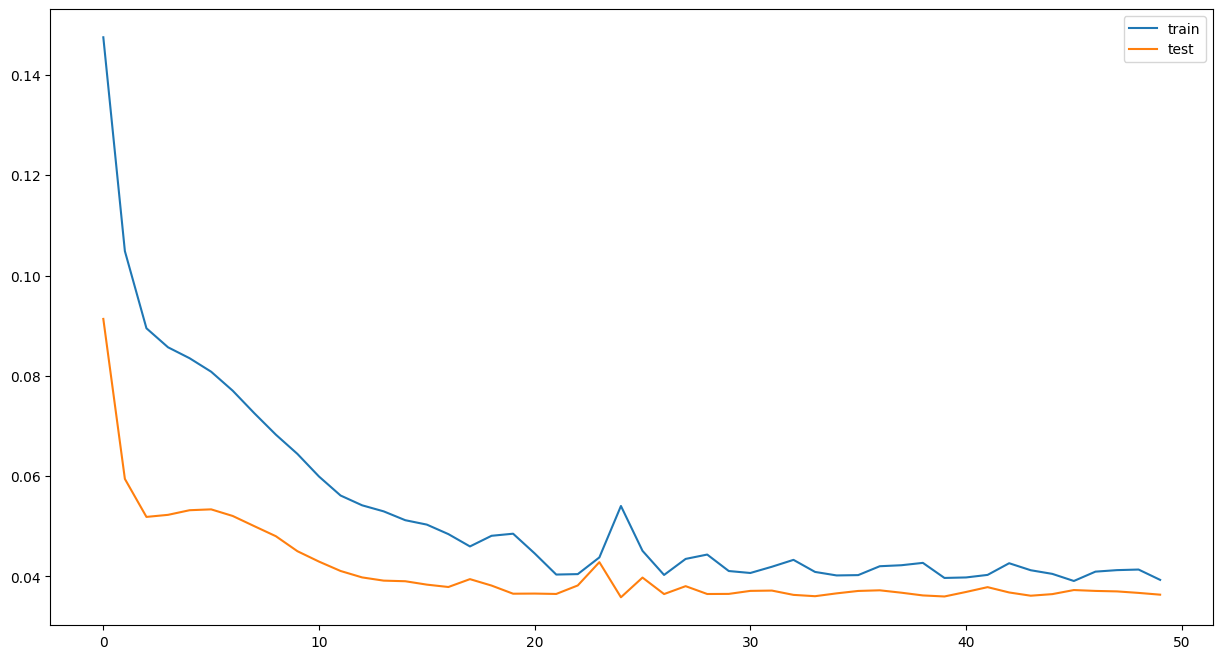

In [43]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [44]:
# make a prediction
pred_y = model.predict(vec_test_X)

8/8 [==============================] - 1s 6ms/step


In [45]:
pred_y[:5]

array([[0.0819352 , 0.06808169, 0.08647168, 0.07029766, 0.09263814],
       [0.08408549, 0.07089918, 0.09003031, 0.07286394, 0.0957327 ],
       [0.0856507 , 0.07589992, 0.09137475, 0.07665408, 0.09672243],
       [0.08757096, 0.08200176, 0.09279522, 0.08148776, 0.09776502],
       [0.08867098, 0.08607076, 0.0934023 , 0.08479048, 0.09820884]],
      dtype=float32)

In [46]:
pred_y.shape

(232, 5)

## Resacling Prediction

In [47]:
data_pred = test_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)

In [48]:
for i in range(0,5):
  data_pred['prediction_t'+str(i)] = pred_y[:,i]

In [49]:
data_pred

,feature_t1,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,feature_t8,feature_t9,feature_t10,...,feature_t26,feature_t27,feature_t28,feature_t29,feature_t30,prediction_t0,prediction_t1,prediction_t2,prediction_t3,prediction_t4
arrival_date,,,,,,,,,,,,,,,,,,,,,
2022-07-23,0.081034,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,0.111667,0.133333,0.145000,...,0.311667,0.321667,0.388333,0.421667,0.388333,0.081935,0.068082,0.086472,0.070298,0.092638
2022-07-24,0.091379,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,0.111667,0.133333,...,0.245000,0.311667,0.321667,0.388333,0.421667,0.084085,0.070899,0.090030,0.072864,0.095733
2022-07-25,0.081034,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,0.111667,...,0.145000,0.245000,0.311667,0.321667,0.388333,0.085651,0.075900,0.091375,0.076654,0.096722
2022-07-26,0.091379,0.111667,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,...,0.121667,0.145000,0.245000,0.311667,0.321667,0.087571,0.082002,0.092795,0.081488,0.097765
2022-07-27,0.091379,0.121667,0.111667,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,...,0.166667,0.121667,0.145000,0.245000,0.311667,0.088671,0.086071,0.093402,0.084790,0.098209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.137931,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,0.211667,0.200000,0.188333,...,0.200000,0.178333,0.166667,0.155000,0.178333,0.158952,0.168916,0.163131,0.168181,0.168065
2023-03-10,0.184483,0.166667,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,0.211667,0.200000,...,0.200000,0.200000,0.178333,0.166667,0.155000,0.160471,0.170761,0.164742,0.169996,0.169345
2023-03-11,0.172414,0.211667,0.166667,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,0.211667,...,0.211667,0.200000,0.200000,0.178333,0.166667,0.160148,0.169441,0.164805,0.168881,0.169220


In [50]:
inv_pred_y = scaler.inverse_transform(data_pred)
inv_pred_y = inv_pred_y[:,-5:]

In [51]:
# Display Predicted values
inv_pred_y[:5,]

array([[675.22418648, 594.87381279, 701.53572559, 607.72641897,
        737.30122596],
       [687.69586682, 611.21525019, 722.17581272, 622.61083126,
        755.24963886],
       [696.77408785, 640.21954387, 729.97357845, 644.59364414,
        760.99010259],
       [707.91155547, 675.61021149, 738.21225017, 672.6290077 ,
        767.03712195],
       [714.29170668, 699.21041429, 741.73331857, 691.78480208,
        769.61125582]])

## Rescaling Actuals

In [52]:
data_actual= test_data

In [53]:
inv_test_y = scaler.inverse_transform(data_actual)
inv_test_y = inv_test_y[:,-5:]

In [54]:
# Display Actual target values
inv_test_y[:5,]

array([[730., 670., 730., 730., 470.],
       [670., 730., 730., 470., 530.],
       [730., 730., 470., 530., 600.],
       [730., 470., 530., 600., 670.],
       [470., 530., 600., 670., 670.]])

In [55]:
inv_test_y.shape

(232, 5)

## Comparing Actuals vs Predicted

In [56]:
pred_df = test_data[['feature_t1']]

In [57]:
for i in range(0,5):
  pred_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred_df['prediction_t'+str(i+1)] = inv_pred_y[:,i]

In [58]:
pred_df

,feature_t1,modal_price_actual_t1,prediction_t1,modal_price_actual_t2,prediction_t2,modal_price_actual_t3,prediction_t3,modal_price_actual_t4,prediction_t4,modal_price_actual_t5,prediction_t5
arrival_date,,,,,,,,,,,
2022-07-23,0.081034,730.0,675.224186,670.0,594.873813,730.0,701.535726,730.0,607.726419,470.0,737.301226
2022-07-24,0.091379,670.0,687.695867,730.0,611.215250,730.0,722.175813,470.0,622.610831,530.0,755.249639
2022-07-25,0.081034,730.0,696.774088,730.0,640.219544,470.0,729.973578,530.0,644.593644,600.0,760.990103
2022-07-26,0.091379,730.0,707.911555,470.0,675.610211,530.0,738.212250,600.0,672.629008,670.0,767.037122
2022-07-27,0.091379,470.0,714.291707,530.0,699.210414,600.0,741.733319,670.0,691.784802,670.0,769.611256
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.137931,1270.0,1121.920896,1200.0,1179.715577,1000.0,1146.159706,930.0,1175.449207,870.0,1174.778709
2023-03-10,0.184483,1200.0,1130.734348,1000.0,1190.411404,930.0,1155.502263,870.0,1185.974774,930.0,1182.201988
2023-03-11,0.172414,1000.0,1128.861135,930.0,1182.756415,870.0,1155.870268,930.0,1179.509190,730.0,1181.477299


In [59]:
# Calculate the error
#print("Results of sklearn.metrics:")
#for i in range(1,6):
#  print("MAPE_",i,": %.3f" % mean_absolute_percentage_error(inv_test_y[:,-1*i],inv_pred_y[:,-1*i]))

# Output without the drop NA in features generation

In [60]:
# Calculate the error
error1 = pd.Series()
for i in range(0,5):
  error1['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred_y[:,i])
print("Results of sklearn.metrics:")
print(error1)

Results of sklearn.metrics:
MAPE_1    0.170086
MAPE_2    0.197708
MAPE_3    0.207318
MAPE_4    0.224439
MAPE_5    0.239992
dtype: float64


In [61]:
model_comparision = pd.DataFrame(data = error1)
model_comparision.rename(columns={0:'LSTM'}, inplace= True)
model_comparision

,LSTM
MAPE_1,0.170086
MAPE_2,0.197708
MAPE_3,0.207318
MAPE_4,0.224439
MAPE_5,0.239992


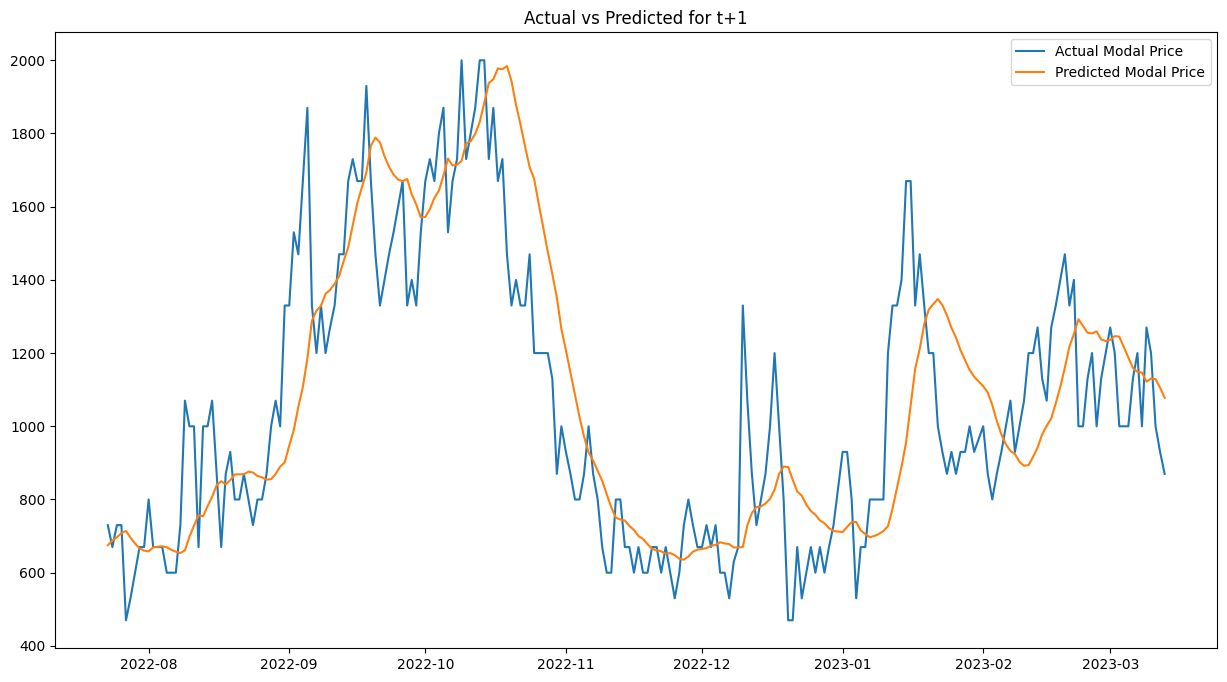

In [62]:
plt.plot(pred_df['modal_price_actual_t1'], label='Actual Modal Price')
plt.plot(pred_df['prediction_t1'],  label='Predicted Modal Price')
plt.legend()
plt.title('Actual vs Predicted for t+1')
plt.show()

# Model 2 - Stacked LSTM

## Model Building

In [63]:
# Build the Stacked LSTM model
model_stacked = Sequential()
model_stacked.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_stacked.add(LSTM(50, activation='relu'))
model_stacked.add(Dense(vec_train_y.shape[1]))
model_stacked.compile(optimizer='adam', loss='mae')

In [64]:
# fit network
history_2 = model_stacked.fit(vec_train_X, vec_train_y, epochs=50, batch_size=72, 
                              validation_data=(vec_test_X, vec_test_y), verbose=2,
                              shuffle=False)

Epoch 1/50
13/13 - 6s - loss: 0.1405 - val_loss: 0.0796 - 6s/epoch - 476ms/step
Epoch 2/50
13/13 - 1s - loss: 0.0992 - val_loss: 0.0554 - 970ms/epoch - 75ms/step
Epoch 3/50
13/13 - 2s - loss: 0.0893 - val_loss: 0.0500 - 2s/epoch - 126ms/step
Epoch 4/50
13/13 - 1s - loss: 0.0818 - val_loss: 0.0501 - 582ms/epoch - 45ms/step
Epoch 5/50
13/13 - 1s - loss: 0.0787 - val_loss: 0.0529 - 569ms/epoch - 44ms/step
Epoch 6/50
13/13 - 1s - loss: 0.0811 - val_loss: 0.0509 - 574ms/epoch - 44ms/step
Epoch 7/50
13/13 - 1s - loss: 0.0823 - val_loss: 0.0587 - 583ms/epoch - 45ms/step
Epoch 8/50
13/13 - 1s - loss: 0.0766 - val_loss: 0.0476 - 571ms/epoch - 44ms/step
Epoch 9/50
13/13 - 1s - loss: 0.0702 - val_loss: 0.0512 - 608ms/epoch - 47ms/step
Epoch 10/50
13/13 - 1s - loss: 0.0701 - val_loss: 0.0468 - 594ms/epoch - 46ms/step
Epoch 11/50
13/13 - 1s - loss: 0.0663 - val_loss: 0.0448 - 579ms/epoch - 45ms/step
Epoch 12/50
13/13 - 1s - loss: 0.0637 - val_loss: 0.0496 - 589ms/epoch - 45ms/step
Epoch 13/50
13/13

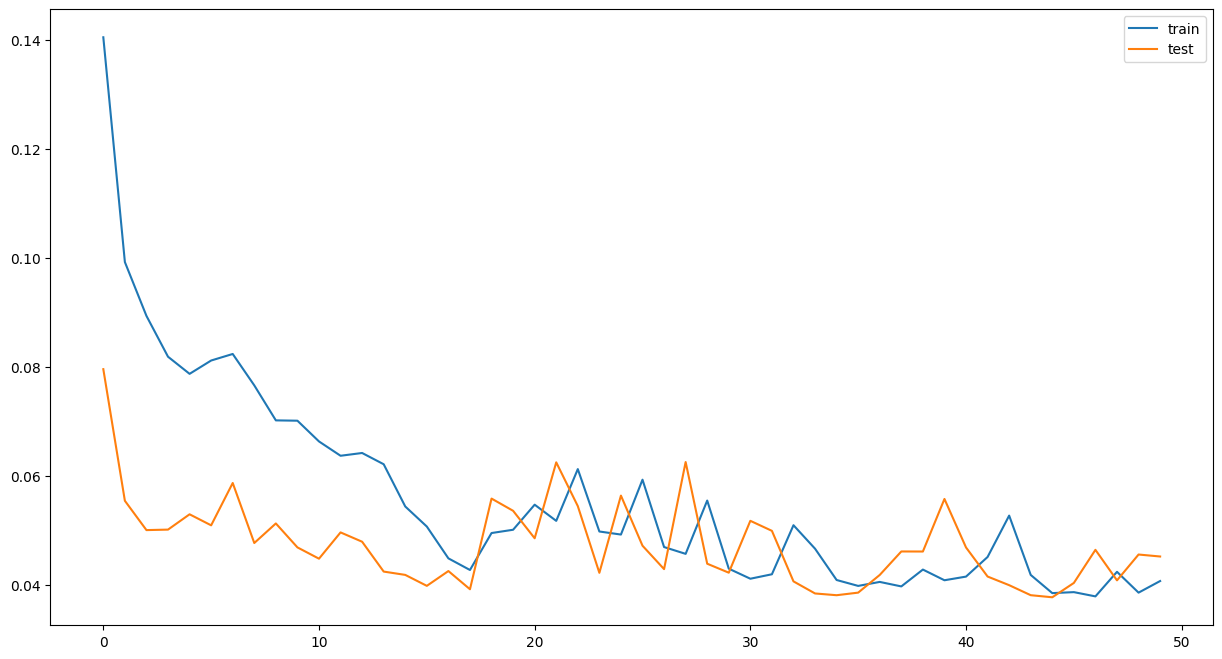

In [65]:
# plot history
plt.plot(history_2.history['loss'], label='train')
plt.plot(history_2.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [66]:
# make a prediction
pred2_y = model_stacked.predict(vec_test_X)

8/8 [==============================] - 0s 11ms/step


In [67]:
pred2_y[:5]

array([[0.08513898, 0.07933728, 0.08127391, 0.07595585, 0.08436783],
       [0.08530064, 0.08052342, 0.08220927, 0.07637761, 0.08558937],
       [0.08448186, 0.08098036, 0.0825887 , 0.07609119, 0.08545547],
       [0.08465805, 0.08233021, 0.08444242, 0.07725943, 0.0866299 ],
       [0.08549225, 0.08421776, 0.0866286 , 0.0791174 , 0.08837817]],
      dtype=float32)

In [68]:
pred2_y.shape

(232, 5)

## Rescaling Prediction

In [69]:
data_pred2 = test_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)

In [70]:
for i in range(0,5):
  data_pred2['prediction_t'+str(i+1)] = pred2_y[:,i]

In [71]:
data_pred2

,feature_t1,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,feature_t8,feature_t9,feature_t10,...,feature_t26,feature_t27,feature_t28,feature_t29,feature_t30,prediction_t1,prediction_t2,prediction_t3,prediction_t4,prediction_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2022-07-23,0.081034,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,0.111667,0.133333,0.145000,...,0.311667,0.321667,0.388333,0.421667,0.388333,0.085139,0.079337,0.081274,0.075956,0.084368
2022-07-24,0.091379,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,0.111667,0.133333,...,0.245000,0.311667,0.321667,0.388333,0.421667,0.085301,0.080523,0.082209,0.076378,0.085589
2022-07-25,0.081034,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,0.111667,...,0.145000,0.245000,0.311667,0.321667,0.388333,0.084482,0.080980,0.082589,0.076091,0.085455
2022-07-26,0.091379,0.111667,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,...,0.121667,0.145000,0.245000,0.311667,0.321667,0.084658,0.082330,0.084442,0.077259,0.086630
2022-07-27,0.091379,0.121667,0.111667,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,...,0.166667,0.121667,0.145000,0.245000,0.311667,0.085492,0.084218,0.086629,0.079117,0.088378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.137931,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,0.211667,0.200000,0.188333,...,0.200000,0.178333,0.166667,0.155000,0.178333,0.189115,0.189807,0.189219,0.188006,0.187500
2023-03-10,0.184483,0.166667,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,0.211667,0.200000,...,0.200000,0.200000,0.178333,0.166667,0.155000,0.192225,0.192607,0.192442,0.191404,0.190947
2023-03-11,0.172414,0.211667,0.166667,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,0.211667,...,0.211667,0.200000,0.200000,0.178333,0.166667,0.195100,0.194958,0.195486,0.194385,0.194141


In [72]:
inv_pred2_y = scaler.inverse_transform(data_pred2)
inv_pred2_y = inv_pred2_y[:,-5:]

In [73]:
inv_pred2_y[:5,]

array([[693.80610734, 660.15620381, 671.38869762, 640.54390341,
        689.33339417],
       [694.74370778, 667.03581512, 676.8137902 , 642.99012572,
        696.41835541],
       [689.99477476, 669.68609095, 679.01447415, 641.32891744,
        695.64172477],
       [691.01668447, 677.51522958, 689.7660464 , 648.10468704,
        702.45344788],
       [695.85502595, 688.46303374, 702.44588554, 658.88093412,
        712.59337813]])

## Comapring Actuals vs Predicted

In [74]:
pred2_df = test_data[['feature_t1']]

In [75]:
for i in range(0,5):
  pred2_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred2_df['prediction_t'+str(i+1)] = inv_pred2_y[:,i]

In [76]:
pred2_df

,feature_t1,modal_price_actual_t1,prediction_t1,modal_price_actual_t2,prediction_t2,modal_price_actual_t3,prediction_t3,modal_price_actual_t4,prediction_t4,modal_price_actual_t5,prediction_t5
arrival_date,,,,,,,,,,,
2022-07-23,0.081034,730.0,693.806107,670.0,660.156204,730.0,671.388698,730.0,640.543903,470.0,689.333394
2022-07-24,0.091379,670.0,694.743708,730.0,667.035815,730.0,676.813790,470.0,642.990126,530.0,696.418355
2022-07-25,0.081034,730.0,689.994775,730.0,669.686091,470.0,679.014474,530.0,641.328917,600.0,695.641725
2022-07-26,0.091379,730.0,691.016684,470.0,677.515230,530.0,689.766046,600.0,648.104687,670.0,702.453448
2022-07-27,0.091379,470.0,695.855026,530.0,688.463034,600.0,702.445886,670.0,658.880934,670.0,712.593378
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.137931,1270.0,1296.867621,1200.0,1300.879118,1000.0,1297.468287,930.0,1290.432632,870.0,1287.498790
2023-03-10,0.184483,1200.0,1314.907819,1000.0,1317.121381,930.0,1316.166365,870.0,1310.144150,930.0,1307.492924
2023-03-11,0.172414,1000.0,1331.580400,930.0,1330.758309,870.0,1333.818853,930.0,1327.432868,730.0,1326.016074


In [77]:
# Calculate the error
error2 = pd.Series()
for i in range(0,5):
  error2['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred2_y[:,i])
print("Results of sklearn.metrics:")
print(error2)

Results of sklearn.metrics:
MAPE_1    0.222186
MAPE_2    0.245834
MAPE_3    0.267442
MAPE_4    0.278910
MAPE_5    0.298930
dtype: float64


In [78]:
model_comparision['Stacked_LSTM'] = error2
model_comparision

,LSTM,Stacked_LSTM
MAPE_1,0.170086,0.222186
MAPE_2,0.197708,0.245834
MAPE_3,0.207318,0.267442
MAPE_4,0.224439,0.278910
MAPE_5,0.239992,0.298930


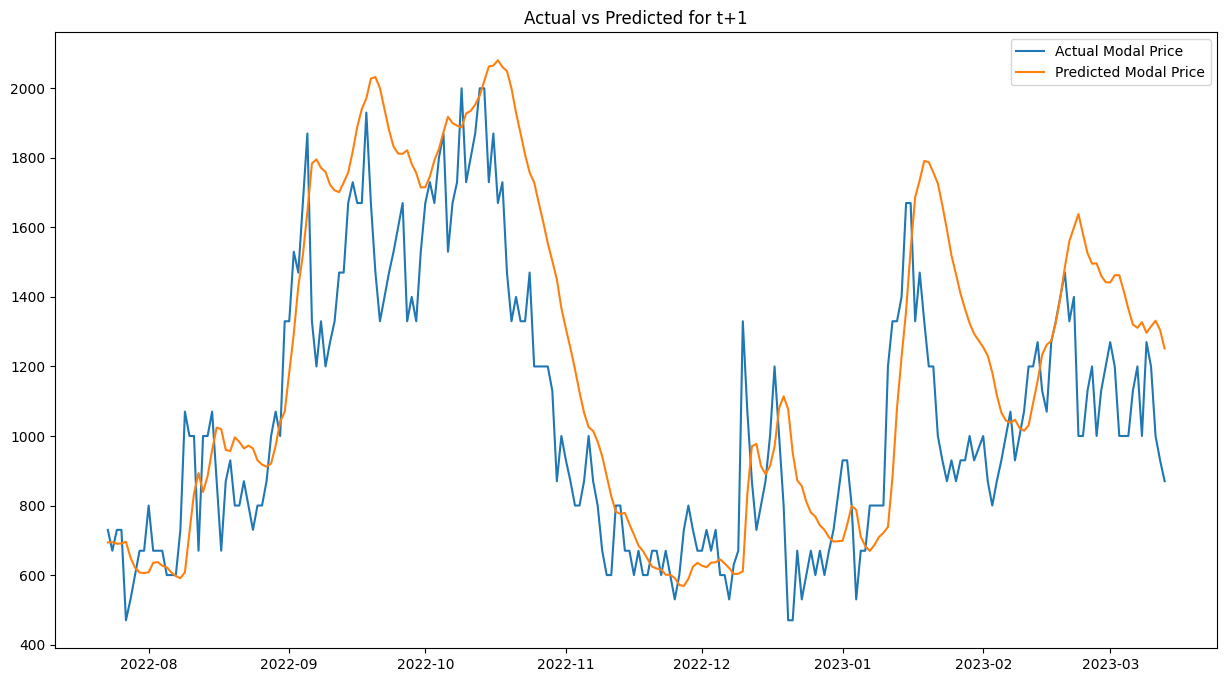

In [79]:
plt.plot(pred2_df['modal_price_actual_t1'], label='Actual Modal Price')
plt.plot(pred2_df['prediction_t1'],  label='Predicted Modal Price')
plt.legend()
plt.title('Actual vs Predicted for t+1')
plt.show()

# Model 3 - Bi Directional LSTM

## Model Building

In [80]:
# Build the Bi-Directional LSTM model
model_biDir = Sequential()
model_biDir.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_biDir.add(Dense(vec_train_y.shape[1]))
model_biDir.compile(optimizer='adam', loss='mae')


In [81]:
model_biDir.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100)              20800     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 5)                 505       
                                                                 
Total params: 21,305
Trainable params: 21,305
Non-trainable params: 0
_________________________________________________________________


In [82]:
# fit network
history_3 = model_biDir.fit(vec_train_X, vec_train_y, epochs=50, batch_size=72, 
                            validation_data=(vec_test_X, vec_test_y), verbose=2,
                            shuffle=False)

Epoch 1/50
13/13 - 4s - loss: 0.1390 - val_loss: 0.0775 - 4s/epoch - 305ms/step
Epoch 2/50
13/13 - 0s - loss: 0.0894 - val_loss: 0.0490 - 486ms/epoch - 37ms/step
Epoch 3/50
13/13 - 0s - loss: 0.0814 - val_loss: 0.0475 - 473ms/epoch - 36ms/step
Epoch 4/50
13/13 - 0s - loss: 0.0767 - val_loss: 0.0476 - 472ms/epoch - 36ms/step
Epoch 5/50
13/13 - 0s - loss: 0.0782 - val_loss: 0.0462 - 462ms/epoch - 36ms/step
Epoch 6/50
13/13 - 0s - loss: 0.0768 - val_loss: 0.0573 - 452ms/epoch - 35ms/step
Epoch 7/50
13/13 - 0s - loss: 0.0719 - val_loss: 0.0448 - 467ms/epoch - 36ms/step
Epoch 8/50
13/13 - 0s - loss: 0.0680 - val_loss: 0.0428 - 444ms/epoch - 34ms/step
Epoch 9/50
13/13 - 0s - loss: 0.0634 - val_loss: 0.0465 - 468ms/epoch - 36ms/step
Epoch 10/50
13/13 - 0s - loss: 0.0637 - val_loss: 0.0423 - 443ms/epoch - 34ms/step
Epoch 11/50
13/13 - 0s - loss: 0.0599 - val_loss: 0.0441 - 446ms/epoch - 34ms/step
Epoch 12/50
13/13 - 1s - loss: 0.0595 - val_loss: 0.0407 - 598ms/epoch - 46ms/step
Epoch 13/50
13/

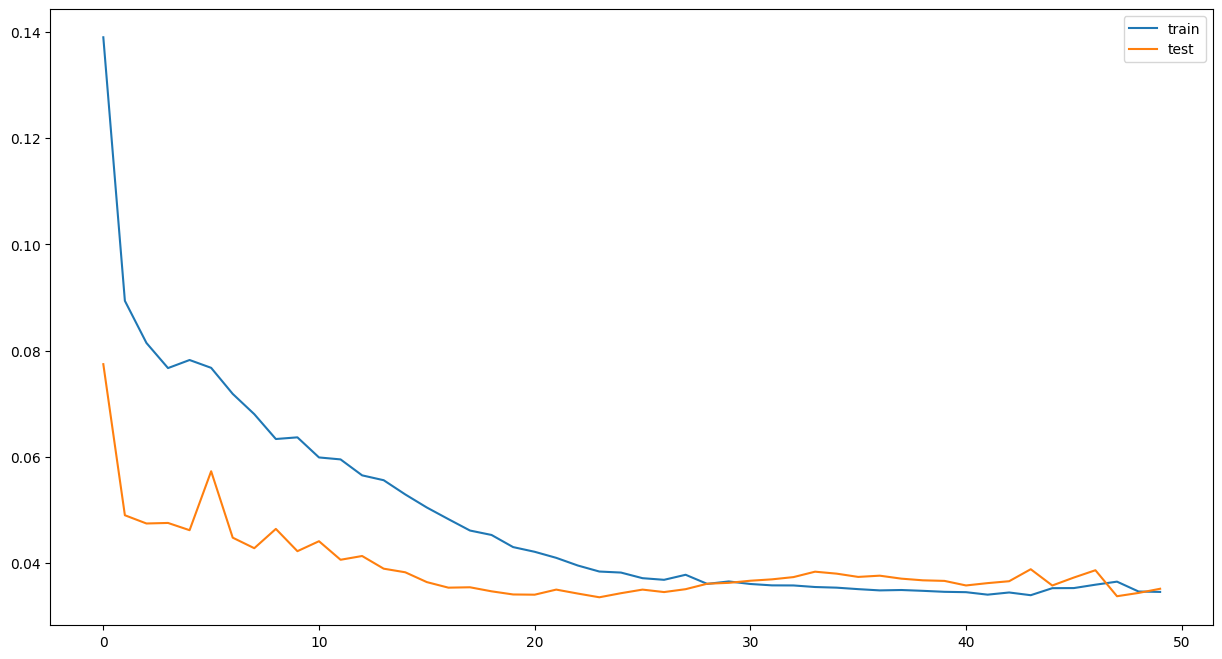

In [83]:
# plot history
plt.plot(history_3.history['loss'], label='train')
plt.plot(history_3.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [84]:
# make a prediction
pred3_y = model_biDir.predict(vec_test_X)

8/8 [==============================] - 0s 8ms/step


In [85]:
pred3_y[:5]

array([[0.07932813, 0.07361096, 0.07100566, 0.07832829, 0.07484753],
       [0.07943419, 0.07368167, 0.07135622, 0.07815429, 0.07508412],
       [0.0773    , 0.07227948, 0.07064493, 0.07624303, 0.07315163],
       [0.0773568 , 0.07295378, 0.07220919, 0.07669193, 0.07318439],
       [0.07793453, 0.07411967, 0.07379837, 0.07725322, 0.07353062]],
      dtype=float32)

In [86]:
pred3_y.shape

(232, 5)

## Rescaling Prediction

In [87]:
data_pred3 = test_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)

In [88]:
for i in range(0,5):
  data_pred3['prediction_t'+str(i+1)] = pred3_y[:,i]

In [89]:
data_pred3

,feature_t1,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,feature_t8,feature_t9,feature_t10,...,feature_t26,feature_t27,feature_t28,feature_t29,feature_t30,prediction_t1,prediction_t2,prediction_t3,prediction_t4,prediction_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2022-07-23,0.081034,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,0.111667,0.133333,0.145000,...,0.311667,0.321667,0.388333,0.421667,0.388333,0.079328,0.073611,0.071006,0.078328,0.074848
2022-07-24,0.091379,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,0.111667,0.133333,...,0.245000,0.311667,0.321667,0.388333,0.421667,0.079434,0.073682,0.071356,0.078154,0.075084
2022-07-25,0.081034,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,0.111667,...,0.145000,0.245000,0.311667,0.321667,0.388333,0.077300,0.072279,0.070645,0.076243,0.073152
2022-07-26,0.091379,0.111667,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,...,0.121667,0.145000,0.245000,0.311667,0.321667,0.077357,0.072954,0.072209,0.076692,0.073184
2022-07-27,0.091379,0.121667,0.111667,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,...,0.166667,0.121667,0.145000,0.245000,0.311667,0.077935,0.074120,0.073798,0.077253,0.073531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.137931,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,0.211667,0.200000,0.188333,...,0.200000,0.178333,0.166667,0.155000,0.178333,0.156894,0.155837,0.153324,0.155940,0.152830
2023-03-10,0.184483,0.166667,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,0.211667,0.200000,...,0.200000,0.200000,0.178333,0.166667,0.155000,0.162032,0.160948,0.158807,0.160537,0.157948
2023-03-11,0.172414,0.211667,0.166667,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,0.211667,...,0.211667,0.200000,0.200000,0.178333,0.166667,0.163697,0.162772,0.160549,0.162052,0.159784


In [90]:
inv_pred3_y = scaler.inverse_transform(data_pred3)
inv_pred3_y = inv_pred3_y[:,-5:]

In [91]:
inv_pred3_y[:5,]

array([[660.103181  , 626.94357634, 611.83285564, 654.30407673,
        634.11565572],
       [660.71828008, 627.35367119, 613.86608779, 653.29487175,
        635.4878962 ],
       [648.33998382, 619.22095865, 609.74059403, 642.20956266,
        624.27942902],
       [648.66944253, 623.13194126, 618.81332695, 644.81316805,
        624.46948141],
       [652.02025026, 629.89409864, 628.03056538, 648.06864709,
        626.47760659]])

## Comapring Actuals vs Predicted

In [92]:
pred3_df = test_data[['feature_t1']]

In [93]:
for i in range(0,5):
  pred3_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred3_df['prediction_t'+str(i+1)] = inv_pred3_y[:,i]

In [94]:
pred3_df

,feature_t1,modal_price_actual_t1,prediction_t1,modal_price_actual_t2,prediction_t2,modal_price_actual_t3,prediction_t3,modal_price_actual_t4,prediction_t4,modal_price_actual_t5,prediction_t5
arrival_date,,,,,,,,,,,
2022-07-23,0.081034,730.0,660.103181,670.0,626.943576,730.0,611.832856,730.0,654.304077,470.0,634.115656
2022-07-24,0.091379,670.0,660.718280,730.0,627.353671,730.0,613.866088,470.0,653.294872,530.0,635.487896
2022-07-25,0.081034,730.0,648.339984,730.0,619.220959,470.0,609.740594,530.0,642.209563,600.0,624.279429
2022-07-26,0.091379,730.0,648.669443,470.0,623.131941,530.0,618.813327,600.0,644.813168,670.0,624.469481
2022-07-27,0.091379,470.0,652.020250,530.0,629.894099,600.0,628.030565,670.0,648.068647,670.0,626.477607
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.137931,1270.0,1109.983289,1200.0,1103.853127,1000.0,1089.281839,930.0,1104.454657,870.0,1086.415929
2023-03-10,0.184483,1200.0,1139.784783,1000.0,1133.496374,930.0,1121.078148,870.0,1131.116700,930.0,1116.100919
2023-03-11,0.172414,1000.0,1149.443403,930.0,1144.076216,870.0,1131.181347,930.0,1139.904225,730.0,1126.750076


In [95]:
# Calculate the error
error3 = pd.Series()
for i in range(0,5):
  error3['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred3_y[:,i])
print("Results of sklearn.metrics:")
print(error3)

Results of sklearn.metrics:
MAPE_1    0.162492
MAPE_2    0.185602
MAPE_3    0.198835
MAPE_4    0.214646
MAPE_5    0.231014
dtype: float64


In [96]:
model_comparision['BiDir_LSTM'] = error3
model_comparision

,LSTM,Stacked_LSTM,BiDir_LSTM
MAPE_1,0.170086,0.222186,0.162492
MAPE_2,0.197708,0.245834,0.185602
MAPE_3,0.207318,0.267442,0.198835
MAPE_4,0.224439,0.278910,0.214646
MAPE_5,0.239992,0.298930,0.231014


# Model 4 - Stacked Bi Directional LSTM

## Model Building

In [97]:
# Build the Stacked Bi-Directional LSTM model
model_Stacked_biDir = Sequential()
model_Stacked_biDir.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True),
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir.add(Bidirectional(LSTM(50, activation='relu')))
model_Stacked_biDir.add(Dense(vec_train_y.shape[1]))
model_Stacked_biDir.compile(optimizer='adam', loss='mae')


In [98]:
# fit network
history_4 = model_Stacked_biDir.fit(vec_train_X, vec_train_y, epochs=50, batch_size=72, 
                                    validation_data=(vec_test_X, vec_test_y), verbose=2,
                                    shuffle=False)

Epoch 1/50
13/13 - 11s - loss: 0.1192 - val_loss: 0.0485 - 11s/epoch - 832ms/step
Epoch 2/50
13/13 - 1s - loss: 0.0812 - val_loss: 0.0463 - 1s/epoch - 87ms/step
Epoch 3/50
13/13 - 1s - loss: 0.0709 - val_loss: 0.0432 - 1s/epoch - 85ms/step
Epoch 4/50
13/13 - 1s - loss: 0.0691 - val_loss: 0.0464 - 1s/epoch - 85ms/step
Epoch 5/50
13/13 - 1s - loss: 0.0722 - val_loss: 0.0459 - 1s/epoch - 84ms/step
Epoch 6/50
13/13 - 1s - loss: 0.0662 - val_loss: 0.0405 - 1s/epoch - 84ms/step
Epoch 7/50
13/13 - 1s - loss: 0.0586 - val_loss: 0.0422 - 1s/epoch - 86ms/step
Epoch 8/50
13/13 - 1s - loss: 0.0583 - val_loss: 0.0382 - 1s/epoch - 83ms/step
Epoch 9/50
13/13 - 1s - loss: 0.0540 - val_loss: 0.0368 - 1s/epoch - 84ms/step
Epoch 10/50
13/13 - 1s - loss: 0.0500 - val_loss: 0.0364 - 1s/epoch - 112ms/step
Epoch 11/50
13/13 - 2s - loss: 0.0489 - val_loss: 0.0346 - 2s/epoch - 157ms/step
Epoch 12/50
13/13 - 2s - loss: 0.0441 - val_loss: 0.0340 - 2s/epoch - 146ms/step
Epoch 13/50
13/13 - 1s - loss: 0.0410 - val

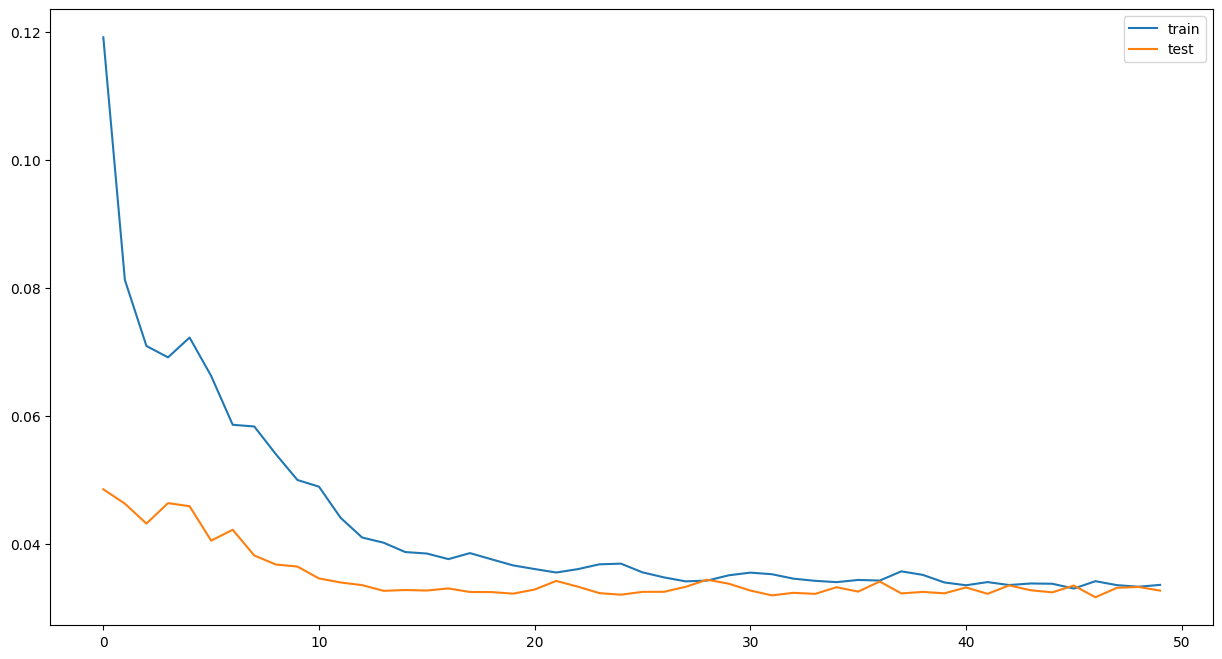

In [99]:
# plot history
plt.plot(history_4.history['loss'], label='train')
plt.plot(history_4.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [100]:
# make a prediction
pred4_y = model_Stacked_biDir.predict(vec_test_X)

8/8 [==============================] - 1s 15ms/step


In [101]:
pred4_y[:5]

array([[0.07719172, 0.07701405, 0.07569943, 0.0798069 , 0.07355313],
       [0.07877554, 0.07764365, 0.07669505, 0.08094345, 0.07520594],
       [0.07739188, 0.07593893, 0.07572135, 0.0797282 , 0.07459688],
       [0.07962804, 0.07771056, 0.07754917, 0.08153781, 0.07761825],
       [0.08190843, 0.07969718, 0.07963835, 0.08366314, 0.08087568]],
      dtype=float32)

In [102]:
pred4_y.shape

(232, 5)

## Rescaling Prediction

In [103]:
data_pred4 = test_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)

In [104]:
for i in range(0,5):
  data_pred4['prediction_t'+str(i+1)] = pred4_y[:,i]

In [105]:
data_pred4

,feature_t1,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,feature_t8,feature_t9,feature_t10,...,feature_t26,feature_t27,feature_t28,feature_t29,feature_t30,prediction_t1,prediction_t2,prediction_t3,prediction_t4,prediction_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2022-07-23,0.081034,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,0.111667,0.133333,0.145000,...,0.311667,0.321667,0.388333,0.421667,0.388333,0.077192,0.077014,0.075699,0.079807,0.073553
2022-07-24,0.091379,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,0.111667,0.133333,...,0.245000,0.311667,0.321667,0.388333,0.421667,0.078776,0.077644,0.076695,0.080943,0.075206
2022-07-25,0.081034,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,0.111667,...,0.145000,0.245000,0.311667,0.321667,0.388333,0.077392,0.075939,0.075721,0.079728,0.074597
2022-07-26,0.091379,0.111667,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,...,0.121667,0.145000,0.245000,0.311667,0.321667,0.079628,0.077711,0.077549,0.081538,0.077618
2022-07-27,0.091379,0.121667,0.111667,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,...,0.166667,0.121667,0.145000,0.245000,0.311667,0.081908,0.079697,0.079638,0.083663,0.080876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.137931,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,0.211667,0.200000,0.188333,...,0.200000,0.178333,0.166667,0.155000,0.178333,0.148548,0.149240,0.150931,0.153584,0.152987
2023-03-10,0.184483,0.166667,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,0.211667,0.200000,...,0.200000,0.200000,0.178333,0.166667,0.155000,0.158330,0.157601,0.158425,0.161917,0.162311
2023-03-11,0.172414,0.211667,0.166667,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,0.211667,...,0.211667,0.200000,0.200000,0.178333,0.166667,0.161567,0.160665,0.161385,0.165155,0.165655


In [106]:
inv_pred4_y = scaler.inverse_transform(data_pred4)
inv_pred4_y = inv_pred4_y[:,-5:]

In [107]:
inv_pred4_y[:5,]

array([[647.71196395, 646.68149799, 639.05667216, 662.88002878,
        626.60815418],
       [656.89813197, 650.33315718, 644.83131766, 669.47201192,
        636.19447798],
       [648.87289107, 640.44576585, 639.1838491 , 662.42356598,
        632.66191483],
       [661.84264868, 650.72125643, 649.78516847, 672.9193151 ,
        650.18584281],
       [675.06892085, 662.24362552, 661.90241277, 685.24618745,
        669.07894313]])

## Comapring Actuals vs Predicted

In [108]:
pred4_df = test_data[['feature_t1']]

In [109]:
for i in range(0,5):
  pred4_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred4_df['prediction_t'+str(i+1)] = inv_pred4_y[:,i]

In [110]:
pred4_df

,feature_t1,modal_price_actual_t1,prediction_t1,modal_price_actual_t2,prediction_t2,modal_price_actual_t3,prediction_t3,modal_price_actual_t4,prediction_t4,modal_price_actual_t5,prediction_t5
arrival_date,,,,,,,,,,,
2022-07-23,0.081034,730.0,647.711964,670.0,646.681498,730.0,639.056672,730.0,662.880029,470.0,626.608154
2022-07-24,0.091379,670.0,656.898132,730.0,650.333157,730.0,644.831318,470.0,669.472012,530.0,636.194478
2022-07-25,0.081034,730.0,648.872891,730.0,640.445766,470.0,639.183849,530.0,662.423566,600.0,632.661915
2022-07-26,0.091379,730.0,661.842649,470.0,650.721256,530.0,649.785168,600.0,672.919315,670.0,650.185843
2022-07-27,0.091379,470.0,675.068921,530.0,662.243626,600.0,661.902413,670.0,685.246187,670.0,669.078943
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.137931,1270.0,1061.581293,1200.0,1065.591407,1000.0,1075.399631,930.0,1090.785664,870.0,1087.323236
2023-03-10,0.184483,1200.0,1118.311974,1000.0,1114.084065,930.0,1118.862253,870.0,1139.119643,930.0,1141.401914
2023-03-11,0.172414,1000.0,1137.088701,930.0,1131.857464,870.0,1136.031616,930.0,1157.899654,730.0,1160.801777


In [111]:
# Calculate the error
error4 = pd.Series()
for i in range(0,5):
  error4['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred4_y[:,i])
print("Results of sklearn.metrics:")
print(error4)

Results of sklearn.metrics:
MAPE_1    0.141685
MAPE_2    0.170424
MAPE_3    0.196427
MAPE_4    0.211876
MAPE_5    0.223176
dtype: float64


In [112]:
model_comparision['Stacked_BiDir_LSTM'] = error4
model_comparision

,LSTM,Stacked_LSTM,BiDir_LSTM,Stacked_BiDir_LSTM
MAPE_1,0.170086,0.222186,0.162492,0.141685
MAPE_2,0.197708,0.245834,0.185602,0.170424
MAPE_3,0.207318,0.267442,0.198835,0.196427
MAPE_4,0.224439,0.278910,0.214646,0.211876
MAPE_5,0.239992,0.298930,0.231014,0.223176


# Model 5 - Stacked Bi Directional LSTM With LSTM

## Model Building

In [129]:
# Build the Stacked Bi-Directional LSTM model
model_Stacked_biDir2 = Sequential()
model_Stacked_biDir2.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True),
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir2.add(LSTM(50, activation='relu'))
model_Stacked_biDir2.add(Dense(vec_train_y.shape[1]))
model_Stacked_biDir2.compile(optimizer='adam', loss='mae')


In [130]:
# fit network
history_5 = model_Stacked_biDir2.fit(vec_train_X, vec_train_y, epochs=50, batch_size=72, 
                                    validation_data=(vec_test_X, vec_test_y), verbose=2,
                                    shuffle=False)

Epoch 1/50
13/13 - 7s - loss: 0.1401 - val_loss: 0.0778 - 7s/epoch - 576ms/step
Epoch 2/50
13/13 - 1s - loss: 0.0977 - val_loss: 0.0536 - 895ms/epoch - 69ms/step
Epoch 3/50
13/13 - 1s - loss: 0.0892 - val_loss: 0.0515 - 822ms/epoch - 63ms/step
Epoch 4/50
13/13 - 1s - loss: 0.0846 - val_loss: 0.0536 - 864ms/epoch - 66ms/step
Epoch 5/50
13/13 - 1s - loss: 0.0818 - val_loss: 0.0539 - 845ms/epoch - 65ms/step
Epoch 6/50
13/13 - 1s - loss: 0.0793 - val_loss: 0.0529 - 818ms/epoch - 63ms/step
Epoch 7/50
13/13 - 1s - loss: 0.0793 - val_loss: 0.0552 - 907ms/epoch - 70ms/step
Epoch 8/50
13/13 - 1s - loss: 0.0847 - val_loss: 0.0539 - 806ms/epoch - 62ms/step
Epoch 9/50
13/13 - 1s - loss: 0.0800 - val_loss: 0.0478 - 829ms/epoch - 64ms/step
Epoch 10/50
13/13 - 1s - loss: 0.0737 - val_loss: 0.0521 - 806ms/epoch - 62ms/step
Epoch 11/50
13/13 - 1s - loss: 0.0739 - val_loss: 0.0499 - 826ms/epoch - 64ms/step
Epoch 12/50
13/13 - 1s - loss: 0.0725 - val_loss: 0.0454 - 1s/epoch - 83ms/step
Epoch 13/50
13/13 

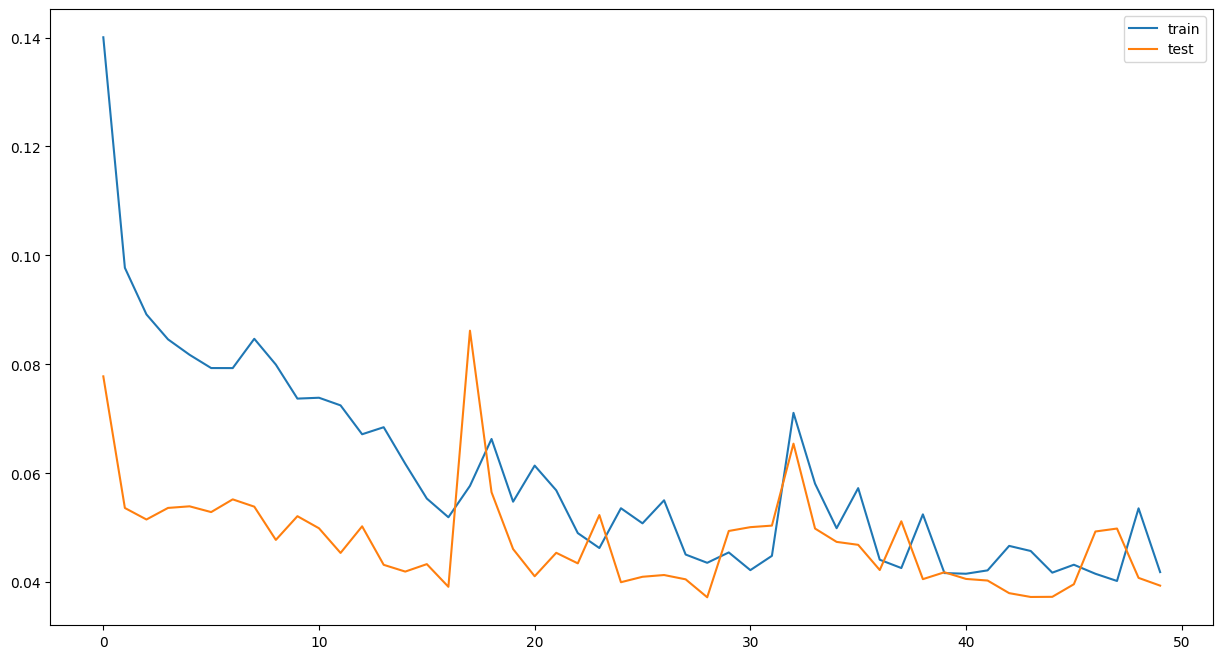

In [131]:
# plot history
plt.plot(history_5.history['loss'], label='train')
plt.plot(history_5.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [132]:
# make a prediction
pred5_y = model_Stacked_biDir2.predict(vec_test_X)

8/8 [==============================] - 1s 13ms/step


In [133]:
pred5_y[:5]

array([[0.06863901, 0.06904182, 0.06886045, 0.06664526, 0.06561419],
       [0.06670631, 0.06701631, 0.06654786, 0.06413886, 0.06309933],
       [0.06428789, 0.06509255, 0.06443333, 0.06218808, 0.0607404 ],
       [0.06269596, 0.06437138, 0.06392366, 0.06157859, 0.05950753],
       [0.06154685, 0.06385966, 0.06358579, 0.06115779, 0.05866367]],
      dtype=float32)

In [134]:
pred5_y.shape

(232, 5)

## Rescaling Prediction

In [135]:
data_pred5 = test_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)

In [136]:
for i in range(0,5):
  data_pred5['prediction_t'+str(i+1)] = pred5_y[:,i]

In [137]:
data_pred5

,feature_t1,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,feature_t8,feature_t9,feature_t10,...,feature_t26,feature_t27,feature_t28,feature_t29,feature_t30,prediction_t1,prediction_t2,prediction_t3,prediction_t4,prediction_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2022-07-23,0.081034,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,0.111667,0.133333,0.145000,...,0.311667,0.321667,0.388333,0.421667,0.388333,0.068639,0.069042,0.068860,0.066645,0.065614
2022-07-24,0.091379,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,0.111667,0.133333,...,0.245000,0.311667,0.321667,0.388333,0.421667,0.066706,0.067016,0.066548,0.064139,0.063099
2022-07-25,0.081034,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,0.111667,...,0.145000,0.245000,0.311667,0.321667,0.388333,0.064288,0.065093,0.064433,0.062188,0.060740
2022-07-26,0.091379,0.111667,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,...,0.121667,0.145000,0.245000,0.311667,0.321667,0.062696,0.064371,0.063924,0.061579,0.059508
2022-07-27,0.091379,0.121667,0.111667,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,...,0.166667,0.121667,0.145000,0.245000,0.311667,0.061547,0.063860,0.063586,0.061158,0.058664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.137931,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,0.211667,0.200000,0.188333,...,0.200000,0.178333,0.166667,0.155000,0.178333,0.158565,0.161248,0.159865,0.163279,0.162174
2023-03-10,0.184483,0.166667,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,0.211667,0.200000,...,0.200000,0.200000,0.178333,0.166667,0.155000,0.161174,0.164157,0.162604,0.166182,0.164815
2023-03-11,0.172414,0.211667,0.166667,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,0.211667,...,0.211667,0.200000,0.200000,0.178333,0.166667,0.161331,0.164514,0.162998,0.166140,0.164882


In [138]:
inv_pred5_y = scaler.inverse_transform(data_pred5)
inv_pred5_y = inv_pred5_y[:,-5:]

In [139]:
inv_pred5_y[:5,]

array([[598.10625911, 600.44254661, 599.3906036 , 586.54249161,
        580.56232333],
       [586.89662516, 588.69460374, 585.97760648, 572.00538516,
        565.97612649],
       [572.86973894, 577.53678262, 573.71330708, 560.69085076,
        552.29434222],
       [563.63655478, 573.35403115, 570.75725347, 557.15584606,
        545.14365345],
       [556.97175711, 570.38600743, 568.79757047, 554.71519828,
        540.24926424]])

## Comapring Actuals vs Predicted

In [140]:
pred5_df = test_data[['feature_t1']]

In [141]:
for i in range(0,5):
  pred5_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred5_df['prediction_t'+str(i+1)] = inv_pred5_y[:,i]

In [142]:
pred5_df

,feature_t1,modal_price_actual_t1,prediction_t1,modal_price_actual_t2,prediction_t2,modal_price_actual_t3,prediction_t3,modal_price_actual_t4,prediction_t4,modal_price_actual_t5,prediction_t5
arrival_date,,,,,,,,,,,
2022-07-23,0.081034,730.0,598.106259,670.0,600.442547,730.0,599.390604,730.0,586.542492,470.0,580.562323
2022-07-24,0.091379,670.0,586.896625,730.0,588.694604,730.0,585.977606,470.0,572.005385,530.0,565.976126
2022-07-25,0.081034,730.0,572.869739,730.0,577.536783,470.0,573.713307,530.0,560.690851,600.0,552.294342
2022-07-26,0.091379,730.0,563.636555,470.0,573.354031,530.0,570.757253,600.0,557.155846,670.0,545.143653
2022-07-27,0.091379,470.0,556.971757,530.0,570.386007,600.0,568.797570,670.0,554.715198,670.0,540.249264
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.137931,1270.0,1119.677517,1200.0,1135.236663,1000.0,1127.217644,930.0,1147.015762,870.0,1140.611887
2023-03-10,0.184483,1200.0,1134.811962,1000.0,1152.110618,930.0,1143.104088,870.0,1163.852727,930.0,1155.928260
2023-03-11,0.172414,1000.0,1135.719615,930.0,1154.178983,870.0,1145.389470,930.0,1163.613930,730.0,1156.317008


In [143]:
# Calculate the error
error5 = pd.Series()
for i in range(0,5):
  error5['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred5_y[:,i])
print("Results of sklearn.metrics:")
print(error5)

Results of sklearn.metrics:
MAPE_1    0.192049
MAPE_2    0.207014
MAPE_3    0.217339
MAPE_4    0.240168
MAPE_5    0.253901
dtype: float64


In [144]:
model_comparision['Stacked_BiDir_LSTM_2'] = error5
model_comparision

,LSTM,Stacked_LSTM,BiDir_LSTM,Stacked_BiDir_LSTM,Stacked_BiDir_LSTM_2
MAPE_1,0.170086,0.222186,0.162492,0.141685,0.192049
MAPE_2,0.197708,0.245834,0.185602,0.170424,0.207014
MAPE_3,0.207318,0.267442,0.198835,0.196427,0.217339
MAPE_4,0.224439,0.278910,0.214646,0.211876,0.240168
MAPE_5,0.239992,0.298930,0.231014,0.223176,0.253901


# Model 6 - Stacked Bi-Dir LSTM (Model 4 with more Epochs).

## Model Building

In [145]:
# Build the Stacked Bi-Directional LSTM model
model_Stacked_biDir3 = Sequential()
model_Stacked_biDir3.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True),
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir3.add(Bidirectional(LSTM(50, activation='relu')))
model_Stacked_biDir3.add(Dense(vec_train_y.shape[1]))
model_Stacked_biDir3.compile(optimizer='adam', loss='mae')

In [146]:
# fit network
history_6 = model_Stacked_biDir3.fit(vec_train_X, vec_train_y, epochs=50, batch_size=100, 
                                    validation_data=(vec_test_X, vec_test_y), verbose=2,
                                    shuffle=False)

Epoch 1/50
10/10 - 10s - loss: 0.1272 - val_loss: 0.0534 - 10s/epoch - 964ms/step
Epoch 2/50
10/10 - 1s - loss: 0.0813 - val_loss: 0.0489 - 1s/epoch - 116ms/step
Epoch 3/50
10/10 - 1s - loss: 0.0741 - val_loss: 0.0435 - 1s/epoch - 115ms/step
Epoch 4/50
10/10 - 1s - loss: 0.0672 - val_loss: 0.0429 - 1s/epoch - 116ms/step
Epoch 5/50
10/10 - 1s - loss: 0.0622 - val_loss: 0.0464 - 1s/epoch - 137ms/step
Epoch 6/50
10/10 - 2s - loss: 0.0638 - val_loss: 0.0432 - 2s/epoch - 244ms/step
Epoch 7/50
10/10 - 2s - loss: 0.0598 - val_loss: 0.0401 - 2s/epoch - 196ms/step
Epoch 8/50
10/10 - 1s - loss: 0.0593 - val_loss: 0.0421 - 1s/epoch - 121ms/step
Epoch 9/50
10/10 - 1s - loss: 0.0554 - val_loss: 0.0380 - 1s/epoch - 115ms/step
Epoch 10/50
10/10 - 1s - loss: 0.0533 - val_loss: 0.0382 - 1s/epoch - 115ms/step
Epoch 11/50
10/10 - 1s - loss: 0.0501 - val_loss: 0.0368 - 1s/epoch - 122ms/step
Epoch 12/50
10/10 - 1s - loss: 0.0492 - val_loss: 0.0344 - 1s/epoch - 112ms/step
Epoch 13/50
10/10 - 1s - loss: 0.04

In [147]:
# fit network
#history_6 = model_Stacked_biDir3.fit(vec_train_X, vec_train_y, initial_epoch=100, epochs=200,
#                                     batch_size=32, validation_data=(vec_test_X, vec_test_y), 
#                                    verbose=2, shuffle=False)

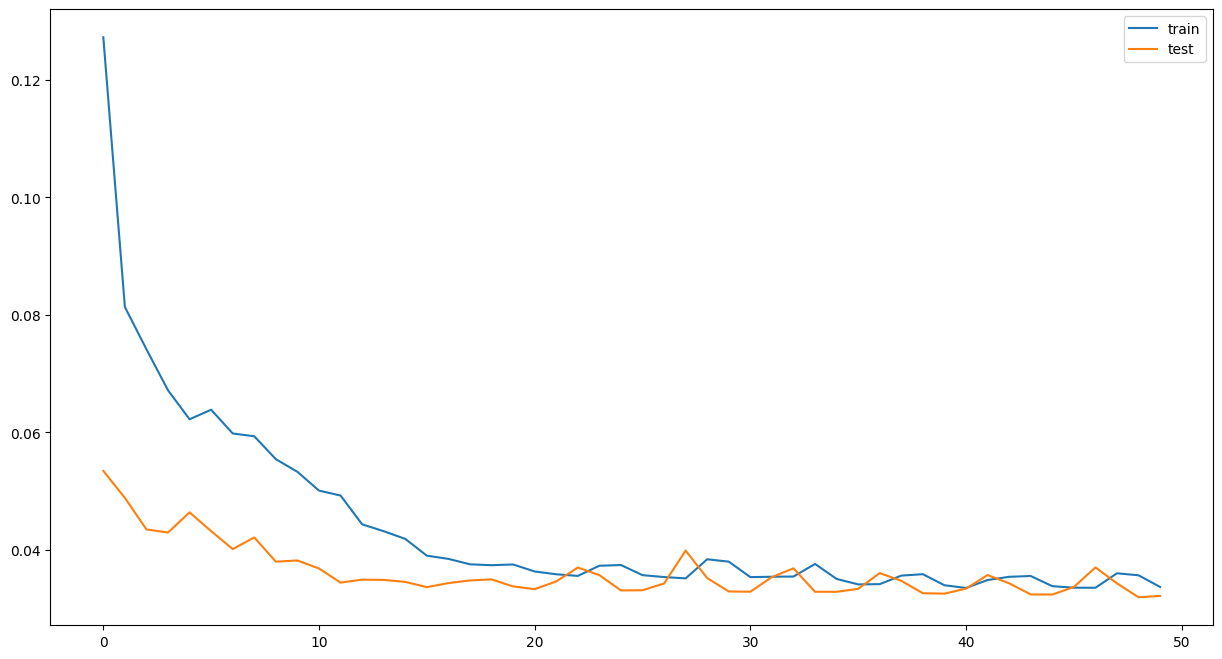

In [148]:
# plot history
plt.plot(history_6.history['loss'], label='train')
plt.plot(history_6.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [149]:
# make a prediction
pred6_y = model_Stacked_biDir3.predict(vec_test_X)

8/8 [==============================] - 1s 16ms/step


In [150]:
pred6_y[:5]

array([[0.07297761, 0.06870662, 0.07264423, 0.06563659, 0.0697739 ],
       [0.07378145, 0.06949163, 0.07313804, 0.06765701, 0.0713134 ],
       [0.07220184, 0.06888159, 0.07233437, 0.06802055, 0.0710241 ],
       [0.0735613 , 0.07114714, 0.07458612, 0.07171778, 0.07331209],
       [0.07529075, 0.07325307, 0.07674907, 0.07502437, 0.07596094]],
      dtype=float32)

In [151]:
pred6_y.shape

(232, 5)

## Rescaling Prediction

In [152]:
data_pred6 = test_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)

In [153]:
for i in range(0,5):
  data_pred6['prediction_t'+str(i+1)] = pred6_y[:,i]

In [154]:
data_pred6

,feature_t1,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,feature_t8,feature_t9,feature_t10,...,feature_t26,feature_t27,feature_t28,feature_t29,feature_t30,prediction_t1,prediction_t2,prediction_t3,prediction_t4,prediction_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2022-07-23,0.081034,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,0.111667,0.133333,0.145000,...,0.311667,0.321667,0.388333,0.421667,0.388333,0.072978,0.068707,0.072644,0.065637,0.069774
2022-07-24,0.091379,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,0.111667,0.133333,...,0.245000,0.311667,0.321667,0.388333,0.421667,0.073781,0.069492,0.073138,0.067657,0.071313
2022-07-25,0.081034,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,0.111667,...,0.145000,0.245000,0.311667,0.321667,0.388333,0.072202,0.068882,0.072334,0.068021,0.071024
2022-07-26,0.091379,0.111667,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,...,0.121667,0.145000,0.245000,0.311667,0.321667,0.073561,0.071147,0.074586,0.071718,0.073312
2022-07-27,0.091379,0.121667,0.111667,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,...,0.166667,0.121667,0.145000,0.245000,0.311667,0.075291,0.073253,0.076749,0.075024,0.075961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.137931,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,0.211667,0.200000,0.188333,...,0.200000,0.178333,0.166667,0.155000,0.178333,0.146355,0.144984,0.149434,0.145210,0.152618
2023-03-10,0.184483,0.166667,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,0.211667,0.200000,...,0.200000,0.200000,0.178333,0.166667,0.155000,0.153490,0.152053,0.156103,0.152876,0.159023
2023-03-11,0.172414,0.211667,0.166667,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,0.211667,...,0.211667,0.200000,0.200000,0.178333,0.166667,0.156102,0.154408,0.158165,0.155320,0.161407


In [155]:
inv_pred6_y = scaler.inverse_transform(data_pred6)
inv_pred6_y = inv_pred6_y[:,-5:]

In [156]:
inv_pred6_y[:5,]

array([[623.27013761, 598.4983772 , 621.33651227, 580.69222271,
        604.68864888],
       [627.93238461, 603.05146724, 624.20060784, 592.41065085,
        613.61774057],
       [618.77067536, 599.51319993, 619.53935474, 594.5192039 ,
        611.93976551],
       [626.65555924, 612.65343428, 632.59947151, 615.96314609,
        625.21011531],
       [636.68633252, 624.86777902, 645.14461458, 635.141325  ,
        640.57346135]])

## Comapring Actuals vs Predicted

In [157]:
pred6_df = test_data[['feature_t1']]

In [158]:
for i in range(0,5):
  pred6_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred6_df['prediction_t'+str(i+1)] = inv_pred6_y[:,i]

In [159]:
pred6_df

,feature_t1,modal_price_actual_t1,prediction_t1,modal_price_actual_t2,prediction_t2,modal_price_actual_t3,prediction_t3,modal_price_actual_t4,prediction_t4,modal_price_actual_t5,prediction_t5
arrival_date,,,,,,,,,,,
2022-07-23,0.081034,730.0,623.270138,670.0,598.498377,730.0,621.336512,730.0,580.692223,470.0,604.688649
2022-07-24,0.091379,670.0,627.932385,730.0,603.051467,730.0,624.200608,470.0,592.410651,530.0,613.617741
2022-07-25,0.081034,730.0,618.770675,730.0,599.513200,470.0,619.539355,530.0,594.519204,600.0,611.939766
2022-07-26,0.091379,730.0,626.655559,470.0,612.653434,530.0,632.599472,600.0,615.963146,670.0,625.210115
2022-07-27,0.091379,470.0,636.686333,530.0,624.867779,600.0,645.144615,670.0,635.141325,670.0,640.573461
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.137931,1270.0,1048.859882,1200.0,1040.910006,1000.0,1066.718844,930.0,1042.215741,870.0,1085.186681
2023-03-10,0.184483,1200.0,1090.239879,1000.0,1081.910244,930.0,1105.397660,870.0,1086.679789,930.0,1122.331855
2023-03-11,0.172414,1000.0,1105.393425,930.0,1095.567569,870.0,1117.358774,930.0,1100.858095,730.0,1136.158404


In [160]:
mean_absolute_percentage_error(inv_test_y[:,0],inv_pred6_y[:,0])

0.14461462538054914

In [161]:
# Calculate the error
error6 = pd.Series()
for i in range(0,5):
  error6['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred6_y[:,i])
print("Results of sklearn.metrics:")
print(error6)

Results of sklearn.metrics:
MAPE_1    0.144615
MAPE_2    0.165130
MAPE_3    0.184620
MAPE_4    0.192964
MAPE_5    0.214855
dtype: float64


In [162]:
model_comparision['Stacked_BiDir_LSTM_3'] = error6
model_comparision

,LSTM,Stacked_LSTM,BiDir_LSTM,Stacked_BiDir_LSTM,Stacked_BiDir_LSTM_2,Stacked_BiDir_LSTM_3
MAPE_1,0.170086,0.222186,0.162492,0.141685,0.192049,0.144615
MAPE_2,0.197708,0.245834,0.185602,0.170424,0.207014,0.165130
MAPE_3,0.207318,0.267442,0.198835,0.196427,0.217339,0.184620
MAPE_4,0.224439,0.278910,0.214646,0.211876,0.240168,0.192964
MAPE_5,0.239992,0.298930,0.231014,0.223176,0.253901,0.214855


# Comparing all models

In [163]:
model_comparision

,LSTM,Stacked_LSTM,BiDir_LSTM,Stacked_BiDir_LSTM,Stacked_BiDir_LSTM_2,Stacked_BiDir_LSTM_3
MAPE_1,0.170086,0.222186,0.162492,0.141685,0.192049,0.144615
MAPE_2,0.197708,0.245834,0.185602,0.170424,0.207014,0.165130
MAPE_3,0.207318,0.267442,0.198835,0.196427,0.217339,0.184620
MAPE_4,0.224439,0.278910,0.214646,0.211876,0.240168,0.192964
MAPE_5,0.239992,0.298930,0.231014,0.223176,0.253901,0.214855
